In [0]:
import numpy as np
import matplotlib.pylab as plt
from scipy.misc import *
%matplotlib inline

Import thedta

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip '/content/drive/My Drive/AI Project/lymphoma-subtype-classification-fl-vs-cll.zip'

Archive:  /content/drive/My Drive/AI Project/lymphoma-subtype-classification-fl-vs-cll.zip
  inflating: X.npy                   
  inflating: Y.npy                   


In [0]:
X = np.load('X.npy') # 
Y = np.load('Y.npy')

**Analysis the data**

In [0]:
print('Total number of images : {}'.format(len(X)))
print('Number of images without cancer : {}'.format(np.sum(Y==0)))
print('Number of images with cancer : {}'.format(np.sum(Y==1)))

Total number of images : 5547
Number of images without cancer : 2759
Number of images with cancer : 2788


In [0]:

print('Percentage of positive images : {:.2f}%'.format(100*np.mean(Y)))

Percentage of positive images : 50.26%


In [0]:
print('Image shape (number of rows, number of columns, channels RGB): {}'.format(X[0].shape))


Image shape (number of rows, number of columns, channels RGB): (50, 50, 3)


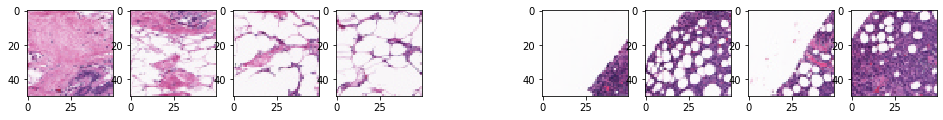

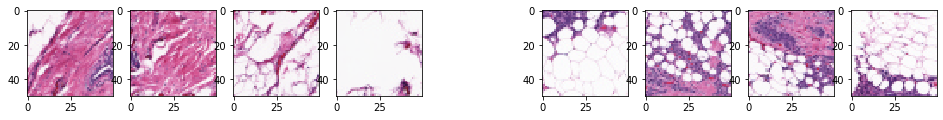

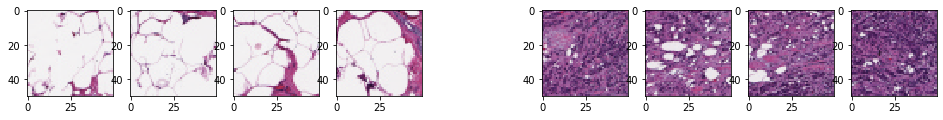

In [0]:
# Looking at some images

imgs0 = X[Y==0] # images with label 0 = no cancer, negative image
imgs1 = X[Y==1] # images with label 1 =    cancer, positive image

batch = 0 

for row in range(3):
    plt.figure(figsize=(20, 10))
    for col in range(4):
        plt.subplot(1,11,col+1)
        plt.imshow(imgs0[50*batch + 5*row+col])
      
        plt.subplot(1,11,col+6)
        plt.imshow(imgs1[50*batch + 5*row+col])

In [0]:
from sklearn.model_selection import StratifiedKFold as KFold

N = len(X)
folds = lambda : KFold(n_splits = 5, shuffle = True, random_state=0).split(X, Y)

for i, (train_indexes, test_indexes) in enumerate(folds()):
    print('split {}: training : {} images, test : {} images'.format(i + 1, len(train_indexes), len(test_indexes)))

split 1: training : 4437 images, test : 1110 images
split 2: training : 4437 images, test : 1110 images
split 3: training : 4437 images, test : 1110 images
split 4: training : 4438 images, test : 1109 images
split 5: training : 4439 images, test : 1108 images


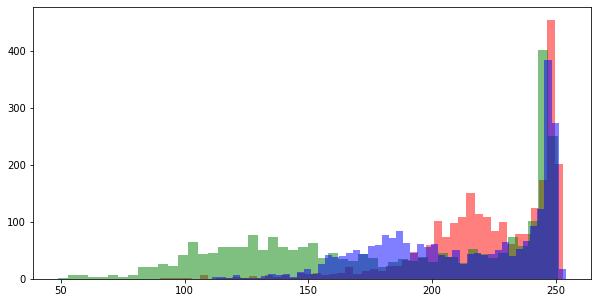

In [0]:
i= 1 # Try 0, 1, 2.. for negative images and -1, -2, -3 for positive images and compare the histograms.
xi = X[i]

plt.figure(figsize=(10,5))
n_bins = 50
plt.hist(xi[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.hist(xi[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.hist(xi[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

In [0]:
histogram_features = []
n_bins = 50 # We decide to keep 50 bins in the histogram, but you can try other values ! (up to 255)
for xi in X:
    hr = np.histogram(xi[:,:,0].flatten(), bins= n_bins)[0]
    hg = np.histogram(xi[:,:,1].flatten(), bins= n_bins)[0]
    hb = np.histogram(xi[:,:,2].flatten(), bins= n_bins)[0]
    hi = np.concatenate([hr, hg, hb])
    histogram_features.append(hi)

histogram_features = np.array(histogram_features)

print('histogram shape : ', histogram_features.shape)

histogram shape :  (5547, 150)


**Import Library for model**

In [0]:
import keras # We use keras library wuth tensorflow backend
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping

Using TensorFlow backend.


In [0]:

# Special callback to see learning curves
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [0]:
# Preprocess the data : center and normalize
X2 = X / 255.
X2 = X2 - np.mean(X2, axis = (0,1,2))
X2 = X2 / np.std(X2, axis = (0,1,2))

**Model**

In [0]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(50, 50, 3))) 
model.add(MaxPooling2D(pool_size=(3, 3)))  

model.add(Conv2D(32, (5, 5), activation='relu')) 
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid')) # output 1 value between 0 and 1 : probability to have cancer
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         


In [0]:
model.compile(loss=keras.losses.binary_crossentropy, # Use binary crossentropy as a loss function  
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history=model.fit(X2[train_indexes], Y[train_indexes],
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data = [X2[test_indexes], Y[test_indexes]],
        callbacks = [MetricsCheckpoint('logs')])




Train on 4439 samples, validate on 1108 samples
Epoch 1/100





4439/4439 [==============================] - 12s 3ms/step - loss: 0.6305 - acc: 0.6824 - val_loss: 0.5604 - val_acc: 0.7292
Epoch 2/100
4439/4439 [==============================] - 11s 2ms/step - loss: 0.5651 - acc: 0.7315 - val_loss: 0.5449 - val_acc: 0.7338
Epoch 3/100
4439/4439 [==============================] - 11s 2ms/step - loss: 0.5589 - acc: 0.7403 - val_loss: 0.5443 - val_acc: 0.7437
Epoch 4/100
4439/4439 [==============================] - 11s 2ms/step - loss: 0.5487 - acc: 0.7448 - val_loss: 0.5385 - val_acc: 0.7410
Epoch 5/100
4439/4439 [==============================] - 11s 2ms/step - loss: 0.5282 - acc: 0.7508 - val_loss: 0.5296 - val_acc: 0.7464
Epoch 6/100
4439/4439 [==============================] - 11s 2ms/step - loss: 0.5274 - acc: 0.7535 - val_loss: 0.5360 - val_acc: 0.7491
Epoch 7/100
4439/4439 [==============================] - 11s 2ms/step - loss: 0.5313 - acc: 0.7563 - val_loss: 0.5504 - val_acc:

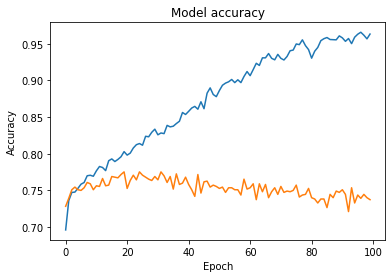

In [51]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()

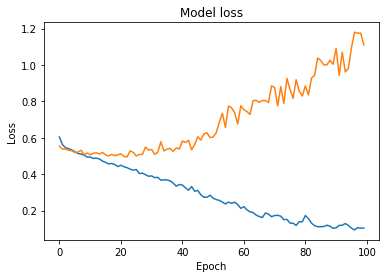

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

**Test The Model**

In [46]:
predict = model.predict(X2[test_indexes])

predicted_id = np.where(predict > 0.5, 1, 0)
predicted_id = predicted_id.T
print("The final result: ",predicted_id[0])

unique, counts = np.unique(predicted_id[0], return_counts=True)
print(np.asarray((unique, counts)).T)

The final result:  [0 1 0 ... 1 1 1]
[[  0 536]
 [  1 572]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

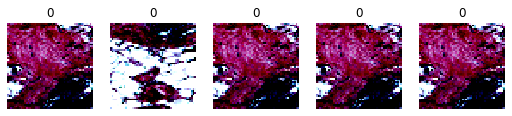

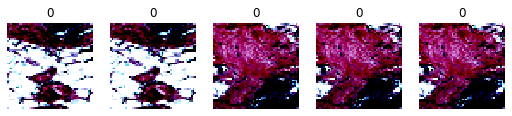

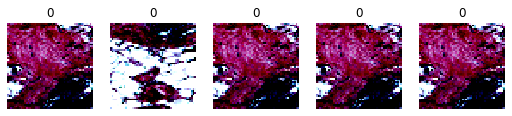

In [24]:
imgs0 = X2[predicted_id[0]]
batch = 0 
for row in range(3):
    i=0
    plt.figure(figsize=(20, 10))
    for col in range(5):
        plt.subplot(1,11,col+1)
        plt.imshow(imgs0[50*batch + 5*row+col])
        plt.title(predicted_id[0][i])
        plt.axis('off')
    i+=1